In [1]:
import os
from pathlib import Path

import numpy as np
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2 as T
from torchvision.models import ResNet18_Weights, resnet18

In [2]:
# for seed reproduction
seed = 42

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

batch_size = 16

root_path = "/kaggle/input/aicc-round-0-brain-tumor"
device = "cuda" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu"

In [3]:
!ls {root_path}

test  train  train.csv


# 1. Data processing

In [4]:
class BrainTumorDataset(Dataset):
    def __init__(self, is_train: bool):
        super().__init__()

        self.is_train = is_train
        self.ds_path = f"{root_path}/{'train' if is_train else 'test'}"

        self.paths = os.listdir(self.ds_path)

        self.transforms = T.Compose([
            T.Resize((224, 224)),
            T.PILToTensor(),
            T.ToDtype(torch.float32, scale=True),
        ])

    def __getitem__(self, idx):
        # format: ./dataset/test/0040.jpg
        img_path = f"{self.ds_path}/{self.paths[idx]}"
        img = Image.open(img_path).convert("RGB")

        img = self.transforms(img)
        return img

    def __len__(self):
        return len(self.paths)

In [5]:
test_ds = BrainTumorDataset(is_train=False)

test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

In [6]:
# sanity check
x = next(iter(test_loader))
x.shape

torch.Size([16, 3, 224, 224])

# 2. Model

In [7]:
# you are not allowed to use any other pretrained model

# you need to have the internet turned on for the notebook, to download the weights (45MB)
resnet = resnet18(weights=ResNet18_Weights.DEFAULT).to(device)
resnet.fc = nn.Identity()

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 204MB/s]


In [8]:
# sanity check
x = x.to(device)
y = resnet(x)
y.shape

torch.Size([16, 512])

# 3. Classification

Baseline approach: cluster images based on their resnet embeddings.

In [9]:
test_images = []

with torch.no_grad():
    for img in tqdm(test_loader):
        img = img.to(device)
        embeddings = resnet(img)
        test_images.append(embeddings)

test_images = torch.cat(test_images, dim=0)

100%|██████████| 82/82 [00:09<00:00,  8.25it/s]


In [10]:
pca = PCA(n_components=2, random_state=seed)

y_2d = pca.fit_transform(test_images.detach().cpu())

In [11]:
km = KMeans(n_clusters=4, random_state=seed)

clusters = km.fit_predict(y_2d)

/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


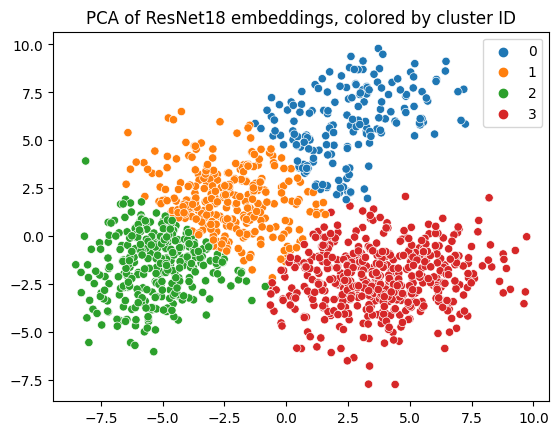

In [12]:
sns.scatterplot(
    x=y_2d[:, 0], y=y_2d[:, 1],
    hue=clusters,
    palette="tab10",
    legend="full"
)
plt.title("PCA of ResNet18 embeddings, colored by cluster ID")
plt.show()

# 4. Submission

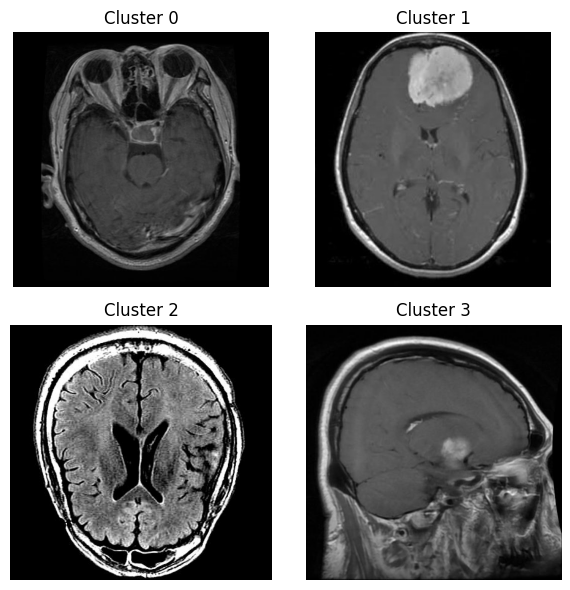

In [13]:
# 1. find images closest to cluster centroids
closest_idx = []
for c in km.cluster_centers_:
    dists = np.linalg.norm(y_2d - c, axis=1)
    closest_idx.append(np.argmin(dists))

# 2. plot them
fig, axes = plt.subplots(2, 2, figsize=(6, 6))
axes = axes.ravel()

image_id2cluster = {i: int(c) for i, c in enumerate(clusters)}

for ax, idx in zip(axes, closest_idx):
    img_path = Path(test_ds.ds_path) / test_ds.paths[idx]
    img = Image.open(img_path).convert("RGB")
    ax.imshow(img)
    ax.set_title(f"Cluster {image_id2cluster[idx]}")
    ax.axis("off")

plt.tight_layout()
plt.show()

In [14]:
"""
1. Is the scan empty?  
   - If the brain tissue looks normal and there is no extra mass, label it "notumor".

2. Is the mass inside the brain tissue itself?  
   - If yes, and it looks like a diffuse, ill-defined grey blob, label it "glioma".

3. Is the mass pushing on the brain from the outside edge (like a cap)?  
   - If yes, and it is round, well-defined, and often attached to the dura, label it "meningioma".

4. Is the mass sitting in the center of the head, between the two halves of the brain?  
   - If yes, and it is round and sitting in or above the pituitary area, label it "pituitary".
"""

id2label = {
	0: "glioma",
	1: "meningioma",
	2: "notumor",
	3: "pituitary",
}

# tip: you can also used the labeled samples, to avoid guessing

In [15]:
preds = [id2label[c] for c in clusters]	
ids = [p[:len(".jpg")] for p in test_ds.paths]

In [16]:
sub = pd.DataFrame({"ID": ids, "prediction": preds})
sub.head()

,ID,prediction
0,0664,meningioma
1,1269,pituitary
2,0733,meningioma
3,0106,notumor
4,0375,pituitary


In [17]:
sub.to_csv("baseline_submission.csv", index=False)